# TOR Detection

## 1- Introduzione
### -Abstract

todo

### -Contesto e motivazioni

todo

### -Obiettivo del progetto

todo


## 2- Setup e Import delle librerie 

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

## 3- Dataset
### -Descrizione dataset 

Descrizione del dataset in generale vedi la fonte ecc todo

### -Caricamento dataset

In [286]:
df = pd.read_csv('../Dataset/SelectedFeatures-10s-TOR-NonTOR.csv')

## 4- EDA e Preprocessing


### 4.1- Esplorazione preliminare

In [287]:
print(df.head(10))

   Source IP   Source Port  Destination IP   Destination Port   Protocol  \
0  10.0.2.15         53913   216.58.208.46                 80          6   
1  10.0.2.15         53913   216.58.208.46                 80          6   
2  10.0.2.15         53913   216.58.208.46                 80          6   
3  10.0.2.15         53913   216.58.208.46                 80          6   
4  10.0.2.15         53913   216.58.208.46                 80          6   
5  10.0.2.15         53913   216.58.208.46                 80          6   
6  10.0.2.15         53913   216.58.208.46                 80          6   
7  10.0.2.15         53913   216.58.208.46                 80          6   
8  10.0.2.15         53913   216.58.208.46                 80          6   
9  10.0.2.15         53913   216.58.208.46                 80          6   

    Flow Duration   Flow Bytes/s   Flow Packets/s   Flow IAT Mean  \
0             435            0.0      4597.701149           435.0   
1             259        

In [288]:
print(df.shape)

(67834, 29)


In [289]:
print(df.columns)

Index(['Source IP', ' Source Port', ' Destination IP', ' Destination Port',
       ' Protocol', ' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min',
       'Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
       'Active Mean', ' Active Std', ' Active Max', ' Active Min', 'Idle Mean',
       ' Idle Std', ' Idle Max', ' Idle Min', 'label'],
      dtype='object')


In [290]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67834 entries, 0 to 67833
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Source IP          67834 non-null  object 
 1    Source Port       67834 non-null  int64  
 2    Destination IP    67834 non-null  object 
 3    Destination Port  67834 non-null  int64  
 4    Protocol          67834 non-null  int64  
 5    Flow Duration     67834 non-null  int64  
 6    Flow Bytes/s      67832 non-null  float64
 7    Flow Packets/s    67834 non-null  float64
 8    Flow IAT Mean     67834 non-null  float64
 9    Flow IAT Std      67834 non-null  float64
 10   Flow IAT Max      67834 non-null  int64  
 11   Flow IAT Min      67834 non-null  int64  
 12  Fwd IAT Mean       67834 non-null  float64
 13   Fwd IAT Std       67834 non-null  float64
 14   Fwd IAT Max       67834 non-null  int64  
 15   Fwd IAT Min       67834 non-null  int64  
 16  Bwd IAT Mean       678

***Features***

spiegazione delle singole features todo

### 4.2- Gestione dati mancanti e duplicati

Viene valutata l'eventuale presenza di campioni duplicati che possono comportare un problema per i modelli

In [291]:
duplicati = df[df.duplicated()]
num_duplicati = df.duplicated().sum()
print('Numero di duplicati: ', num_duplicati)

Numero di duplicati:  396


I campioni duplicati sono stati rimossi

In [292]:
df = df.drop_duplicates()
print(df.shape)

(67438, 29)


Viene valutata la presenza di valori NaN e inf

In [293]:
df = df.replace([np.inf, -np.inf], np.nan)
nan_values = df.isna().sum()
print(nan_values)

Source IP            0
 Source Port         0
 Destination IP      0
 Destination Port    0
 Protocol            0
 Flow Duration       0
 Flow Bytes/s        5
 Flow Packets/s      5
 Flow IAT Mean       0
 Flow IAT Std        0
 Flow IAT Max        0
 Flow IAT Min        0
Fwd IAT Mean         0
 Fwd IAT Std         0
 Fwd IAT Max         0
 Fwd IAT Min         0
Bwd IAT Mean         0
 Bwd IAT Std         0
 Bwd IAT Max         0
 Bwd IAT Min         0
Active Mean          0
 Active Std          0
 Active Max          0
 Active Min          0
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
label                0
dtype: int64


I campioni con valori NaN o inf sono stati rimossi dal dataset

In [294]:
df = df.copy()
df.dropna(inplace=True)
df.shape

(67433, 29)

### 4.3- Raggruppamento delle features

Le features sono state suddivise in tre gruppi (categoriche, numeriche e binarie) che verranno trattati singolarmente.

In [295]:
features_binarie = [col for col in df.columns if df[col].nunique() == 2]
features_binarie.remove('label')
print("Colonne binarie: ", features_binarie)
features_categoriche = df.select_dtypes(include=['object']).columns.tolist()
features_categoriche.remove('label')
print("Colonne categoriche: ", features_categoriche) 
features_numeriche = df.select_dtypes(include=['number']).columns.tolist()
features_numeriche.remove(' Protocol')
print("Colonne numeriche: ", features_numeriche)

Colonne binarie:  [' Protocol']
Colonne categoriche:  ['Source IP', ' Destination IP']
Colonne numeriche:  [' Source Port', ' Destination Port', ' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Active Mean', ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min']


In [296]:
totale_features = len(features_binarie) + len(features_categoriche) + len(features_numeriche)
print("Numero totale di features: ", totale_features)

Numero totale di features:  28


### 4.4- Esplorazione delle features

Verranno analizzate le singole features suddivise per categorie


#### 4.4.1- Esplorazione features binarie

Il dataset contiene un unica feature binaria che è Protocol.

 Protocol
17    55.994839
6     44.005161
Name: proportion, dtype: float64


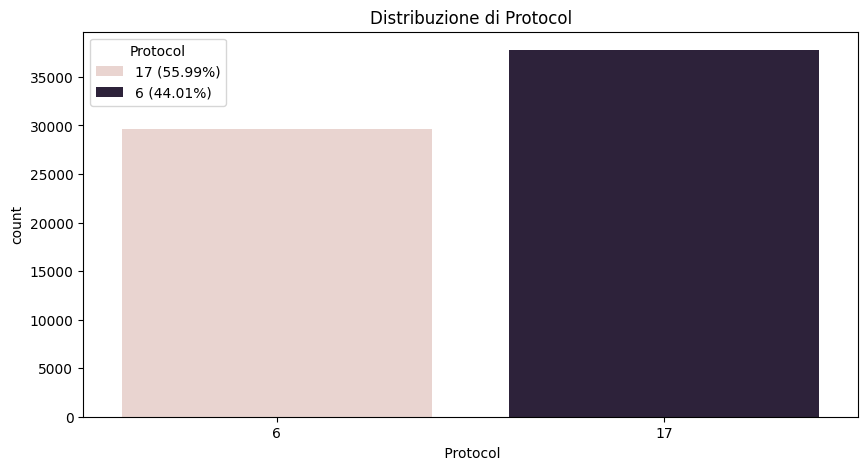

In [297]:
protocol_distribution = df[' Protocol'].value_counts(normalize=True) * 100
print(protocol_distribution)
plt.figure(figsize=(10, 5))
sns.countplot(x=' Protocol', data=df, hue=' Protocol')
plt.title('Distribuzione di Protocol')
plt.legend(title='Protocol', labels=[f'{protocol} ({percentage:.2f}%)' for protocol, percentage in zip(protocol_distribution.index, protocol_distribution)])
plt.show()

I due valori della feature sono 6 e 17 che indicano i protocolli TCP e UDP rispettivamente.

#### 4.4.2 Esplorazione features categoriche

Nel dataset sono presenti due features categoriche: IP sorgente e IP destinazione. Verranno esplorate le due features per capire al meglio come gestirle in seguito. 

In [298]:
num_unique_source_ip = df['Source IP'].nunique()
print(f"Numero di valori unici per 'Source IP': {num_unique_source_ip}")
num_unique_destination_ip = df[' Destination IP'].nunique()
print(f"Numero di valori unici per 'Destination IP': {num_unique_destination_ip}")

Numero di valori unici per 'Source IP': 787
Numero di valori unici per 'Destination IP': 1736


Entrambe assumono un numero molto elevato di valori, quindi si è deciso di osservare con quale frequenza si presenta ogni valore.

In [299]:
source_ip_counts = df['Source IP'].value_counts()
print("Conteggio di ogni valore unico in 'Source IP':")
print(source_ip_counts)

Conteggio di ogni valore unico in 'Source IP':
Source IP
131.202.240.150    9639
10.0.2.15          6320
10.8.0.14          5406
10.8.8.130         5354
131.202.240.242    5184
                   ... 
211.179.39.118        1
188.230.211.38        1
91.190.218.125        1
122.172.69.123        1
74.125.228.232        1
Name: count, Length: 787, dtype: int64


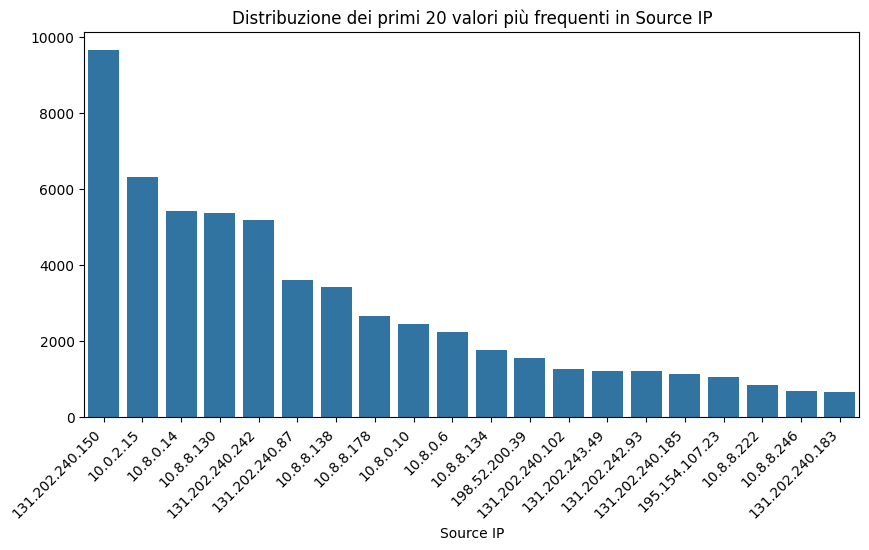

In [300]:
max_values_to_plot = 20
top_source_ip_counts = source_ip_counts.head(max_values_to_plot)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_source_ip_counts.index, y=top_source_ip_counts.values)
plt.title(f'Distribuzione dei primi {max_values_to_plot} valori più frequenti in Source IP')
plt.xticks(rotation=45, ha='right')
plt.show()

In [301]:
destination_ip_counts = df[' Destination IP'].value_counts()
print("Conteggio di ogni valore unico in ' Destination IP':")
print(destination_ip_counts)

Conteggio di ogni valore unico in ' Destination IP':
 Destination IP
224.0.0.252        9899
131.202.244.5      4310
198.7.63.141       4182
131.202.243.255    3609
10.0.2.15          2977
                   ... 
176.194.241.237       1
78.56.120.78          1
151.250.15.29         1
80.174.169.116        1
10.8.8.245            1
Name: count, Length: 1736, dtype: int64


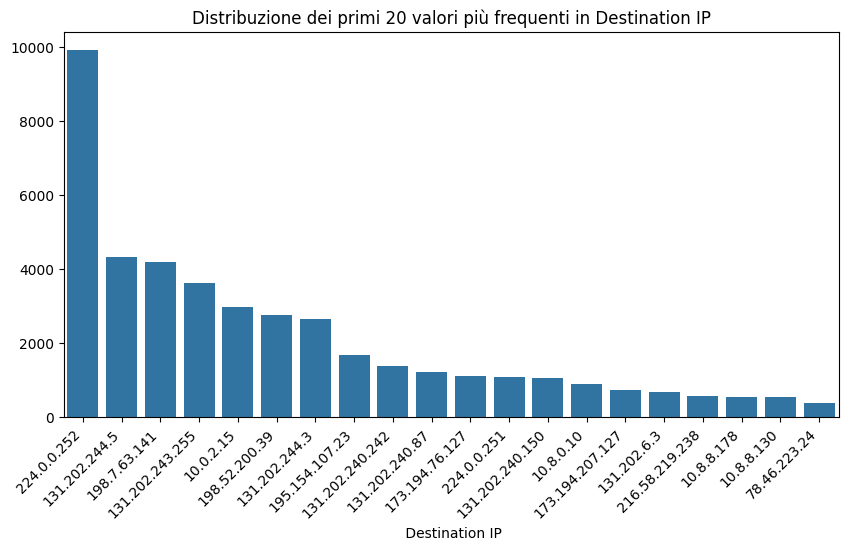

In [302]:
max_values_to_plot = 20
top_destination_ip_counts = destination_ip_counts.head(max_values_to_plot)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_destination_ip_counts.index, y=top_destination_ip_counts.values)
plt.title(f'Distribuzione dei primi {max_values_to_plot} valori più frequenti in Destination IP')
plt.xticks(rotation=45, ha='right')
plt.show()

#### 4.4.3- Esplorazione feature numeriche

In [303]:
df[features_numeriche].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Source Port,67433.0,3.789252e+04,2.099491e+04,21.000000,19305.000000,43623.000000,5.467200e+04,6.553400e+04
Destination Port,67433.0,1.154205e+04,1.839959e+04,21.000000,137.000000,443.000000,1.568500e+04,6.551400e+04
Flow Duration,67433.0,3.009074e+06,4.068738e+06,1.000000,47491.000000,410928.000000,7.424631e+06,1.000000e+07
Flow Bytes/s,67433.0,2.107323e+05,3.999909e+06,0.000000,104.651522,1319.562514,2.152774e+04,6.000000e+08
Flow Packets/s,67433.0,3.032976e+03,4.466077e+04,0.200258,4.861331,16.249858,1.006685e+02,3.000000e+06
Flow IAT Mean,67433.0,3.168673e+05,6.995686e+05,0.500000,9954.755733,86507.250000,4.106330e+05,9.987113e+06
Flow IAT Std,67433.0,2.222802e+05,6.426264e+05,0.000000,0.000000,0.000000,5.952248e+04,7.045491e+06
Flow IAT Max,67433.0,9.031260e+05,1.742099e+06,1.000000,29812.000000,186448.000000,4.756530e+05,9.998126e+06
Flow IAT Min,67433.0,1.929855e+05,5.783539e+05,-2255.000000,26.000000,1305.000000,2.082170e+05,9.987113e+06
Fwd IAT Mean,67433.0,3.516733e+05,8.404145e+05,0.000000,0.000000,19979.530000,4.112770e+05,9.997140e+06


In [304]:
unique_values_count = df[features_numeriche].nunique()
print("Numero di valori unici per ciascuna feature numerica:")
print(unique_values_count)

Numero di valori unici per ciascuna feature numerica:
 Source Port         17578
 Destination Port     2213
 Flow Duration       49973
 Flow Bytes/s        50794
 Flow Packets/s      52222
 Flow IAT Mean       52136
 Flow IAT Std        31179
 Flow IAT Max        49705
 Flow IAT Min        26950
Fwd IAT Mean         37448
 Fwd IAT Std         28016
 Fwd IAT Max         36228
 Fwd IAT Min         18476
Bwd IAT Mean         22956
 Bwd IAT Std         21437
 Bwd IAT Max         22018
 Bwd IAT Min          6718
Active Mean           2498
 Active Std              1
 Active Max           2498
 Active Min           2498
Idle Mean             3007
 Idle Std                1
 Idle Max             3007
 Idle Min             3007
dtype: int64


Dalle prime analisi si notano due features che assumono lo stesso valore per ogni campione del dataset, verranno dunque rimosse.

In [305]:
unique_value_columns = df[features_numeriche].nunique() == 1
columns_to_drop = unique_value_columns[unique_value_columns].index
features_numeriche = [col for col in features_numeriche if col not in columns_to_drop]
df = df.drop(columns=columns_to_drop)
df.shape

(67433, 27)

Vengono ora osservate le distribuzioni delle features numeriche continue, da cui vanno escluse le porte

**VEDERE COME TRATTARE LE PORTE! PER ORA SONO VARIABILI NUMERICHE MA POTREI FARE ENCODING CATEGORICO, RAGGRUPPARLA O PROCESSARLE TIPO FINO ALLA 1024 TUTTE INSIEME O ALTRI MODI**

C:\Users\Tommaso\AppData\Local\Temp\ipykernel_10536\2588539286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric.drop(columns=porte, inplace=True)


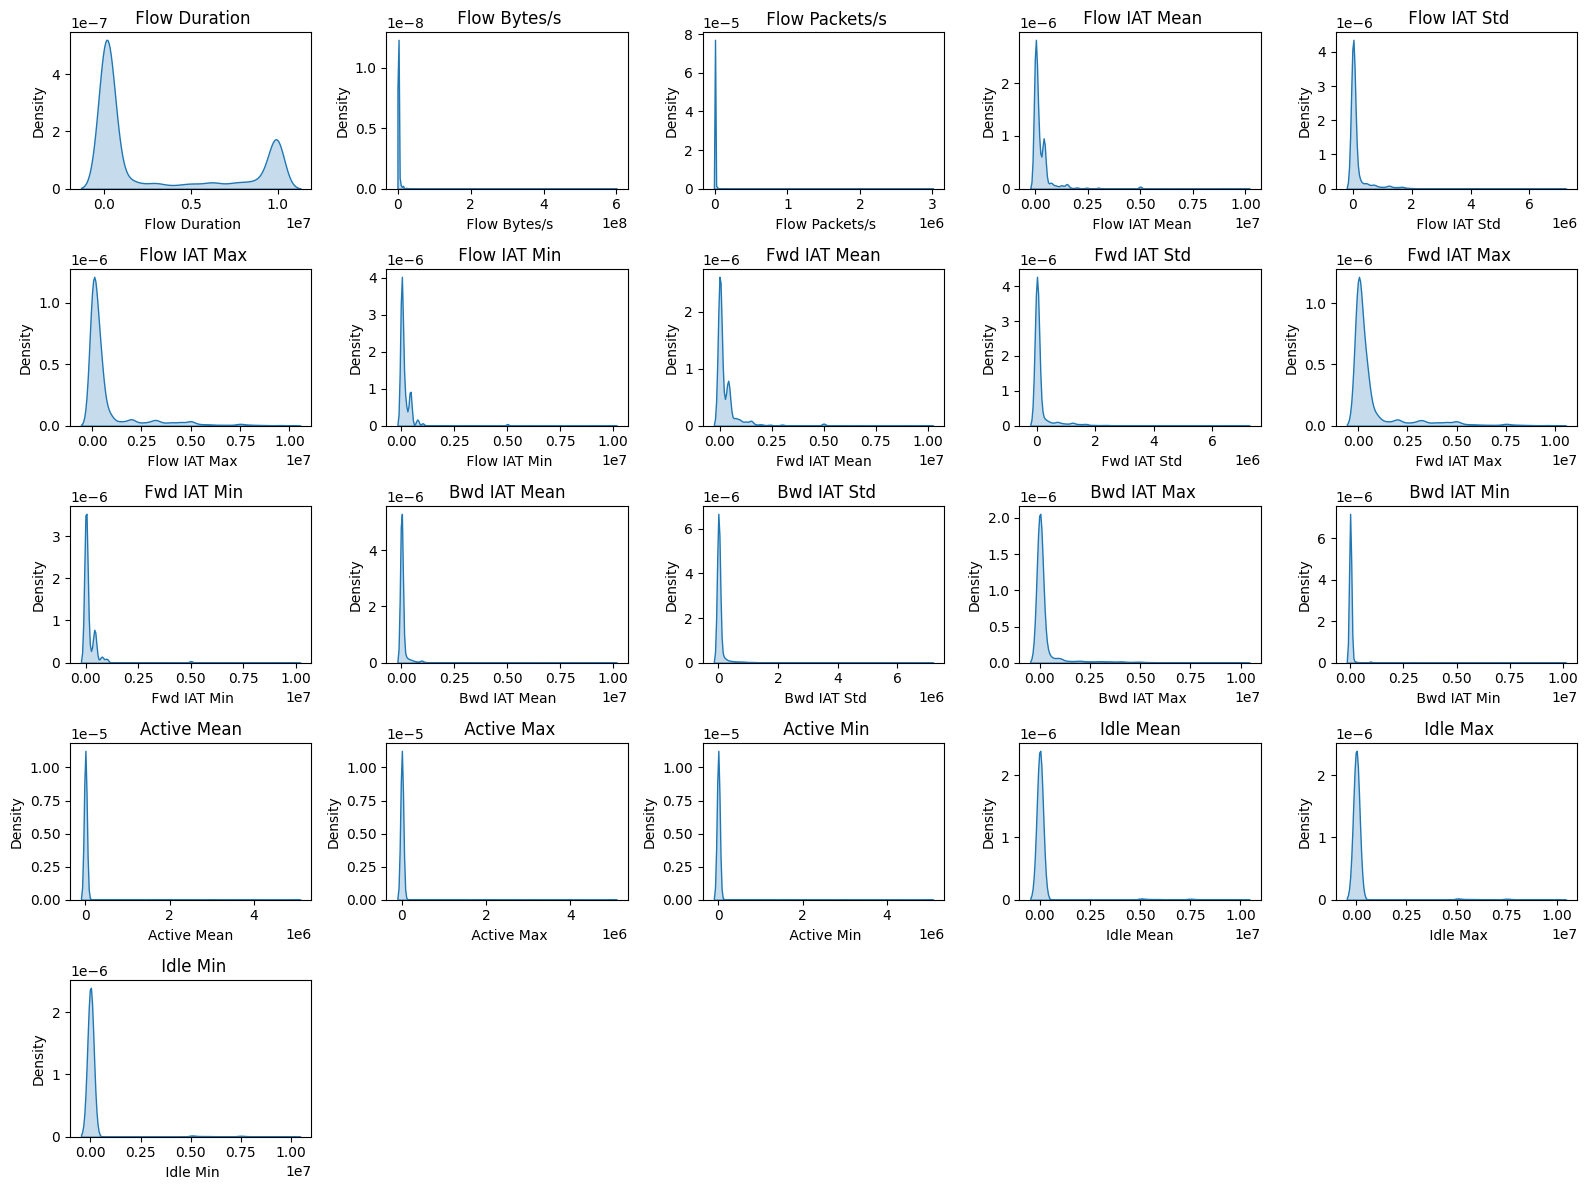

In [306]:
df_numeric = df[features_numeriche]
porte = [' Source Port', ' Destination Port']
df_numeric.drop(columns=porte, inplace=True)

plt.figure(figsize=(16, 12))

for i, column in enumerate(df_numeric.columns, 1):
    plt.subplot(5, 5, i)
    sns.kdeplot(df_numeric[column], fill=True)
    plt.title(column)

plt.tight_layout()
plt.show()

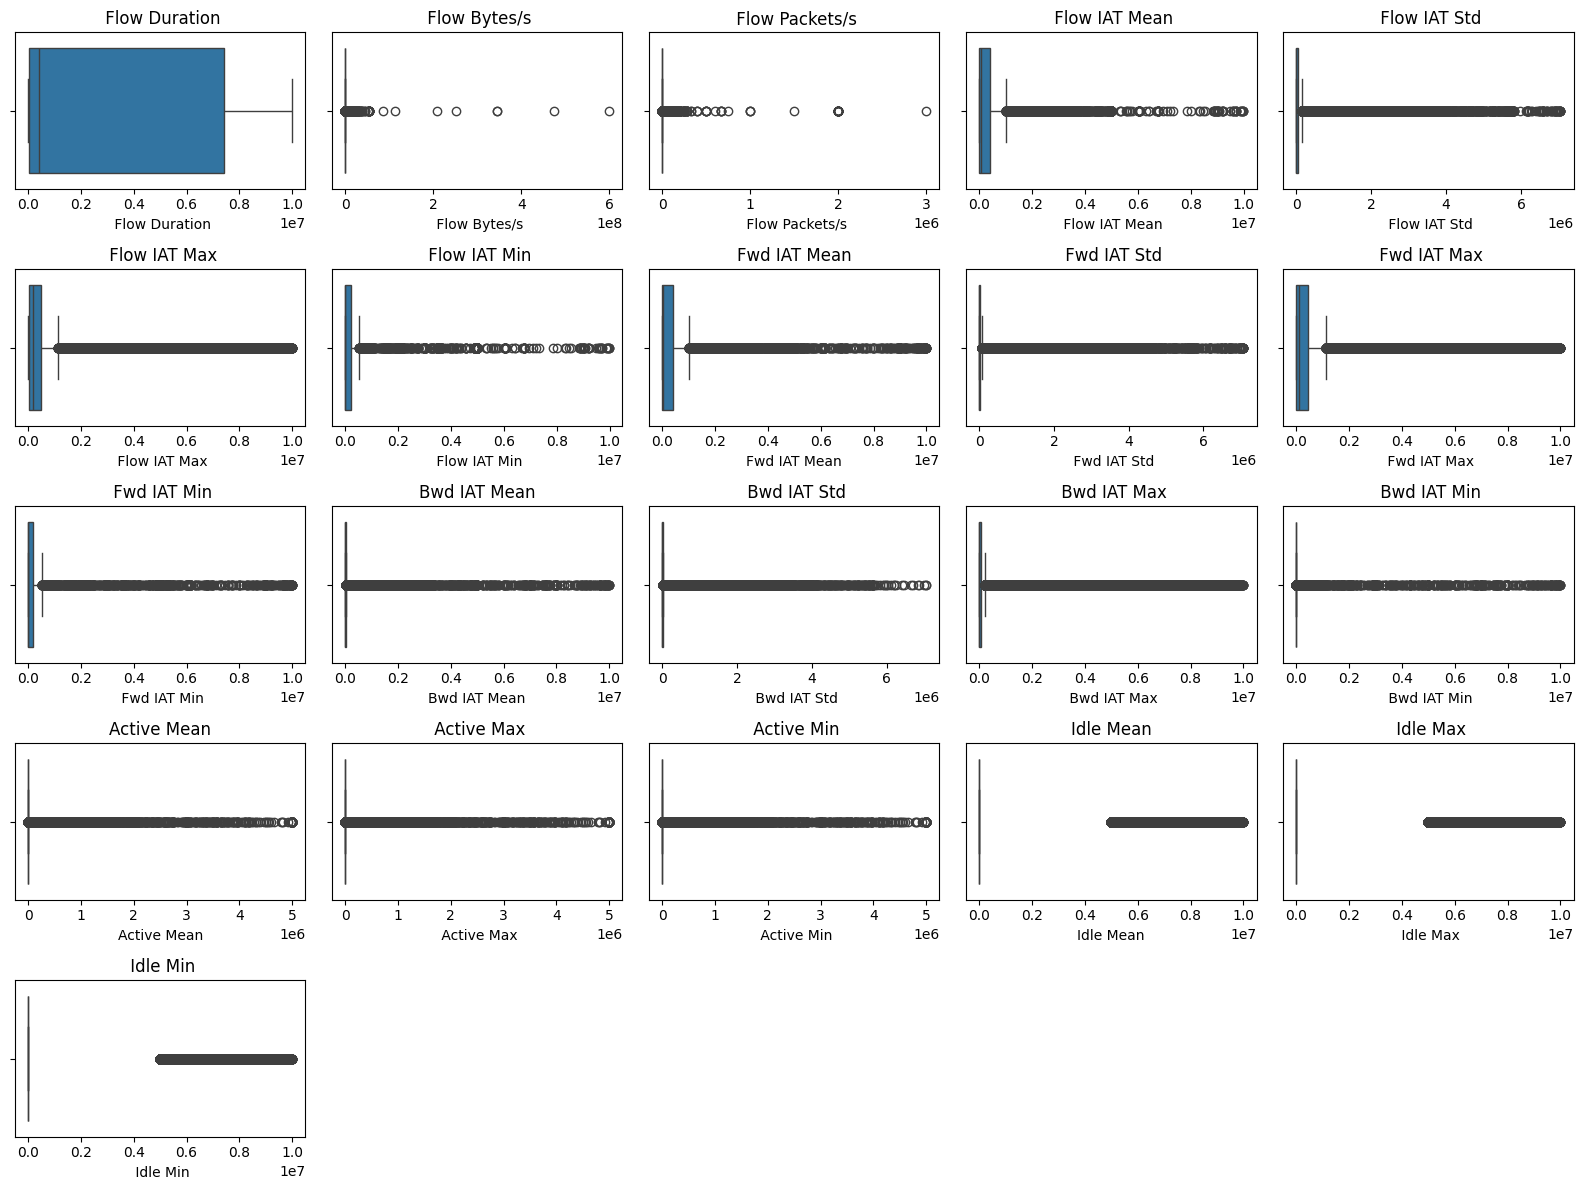

In [307]:
plt.figure(figsize=(16, 12))

for i, column in enumerate(df_numeric.columns, 1):
    plt.subplot(5, 5, i)
    sns.boxplot(x=df_numeric[column])
    plt.title(column)

plt.tight_layout()
plt.show()

Ora osservo separatamente la distribuzione delle porte

In [308]:
df_porte = df[porte]
print(df_porte.nunique())

 Source Port         17578
 Destination Port     2213
dtype: int64


In [309]:
port_count_source = df_porte.groupby([' Source Port']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
print(port_count_source)

        Source Port  Count
12              443   4380
8               137   3017
7216          40273   1575
2622          15685   1257
9660          49539   1232
...             ...    ...
4434          27458      1
4433          27457      1
10732         51648      1
10733         51649      1
8789          46645      1

[17578 rows x 2 columns]


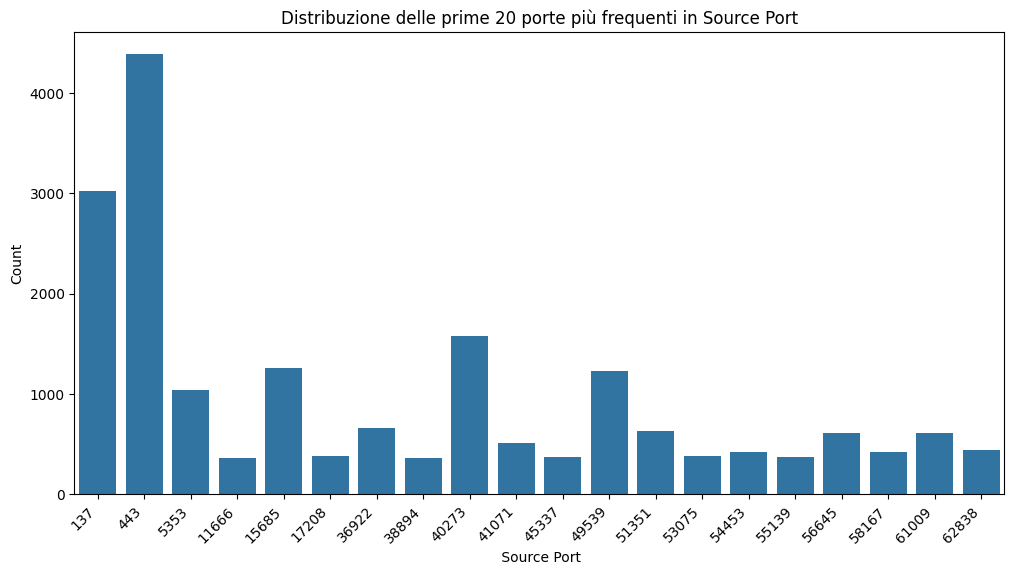

In [310]:
plt.figure(figsize=(12, 6))
sns.barplot(x=' Source Port', y='Count', data=port_count_source.head(20))
plt.title('Distribuzione delle prime 20 porte più frequenti in Source Port')
plt.xticks(rotation=45, ha='right')
plt.show()

In [311]:
port_count_destination = df_porte.groupby([' Destination Port']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
print(port_count_destination)

       Destination Port  Count
14                  443  14863
3                    53  12267
142                5355   9899
6                    80   3608
10                  137   3029
...                 ...    ...
885               37857      1
884               37855      1
883               37854      1
882               37853      1
1106              41586      1

[2213 rows x 2 columns]


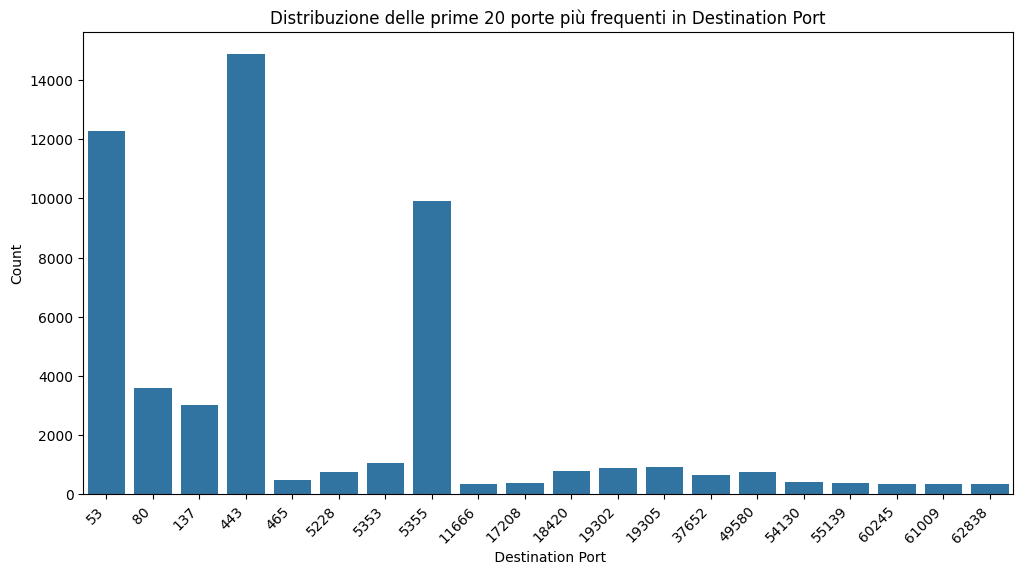

In [312]:
plt.figure(figsize=(12, 6))
sns.barplot(x=' Destination Port', y='Count', data=port_count_destination.head(20))
plt.title('Distribuzione delle prime 20 porte più frequenti in Destination Port')
plt.xticks(rotation=45, ha='right')
plt.show()

### 4.5- Analisi della correlazione

Si analizza ora la correlazione tra le varie features numeriche, in quanto features con correlazioni molto alte potrebbero essere eliminate.

In [313]:
correlation_matrix = df[features_numeriche].corr()
print(correlation_matrix)

                    Source Port   Destination Port   Flow Duration  \
 Source Port           1.000000          -0.315892       -0.217961   
 Destination Port     -0.315892           1.000000        0.283626   
 Flow Duration        -0.217961           0.283626        1.000000   
 Flow Bytes/s         -0.022830           0.008879       -0.019859   
 Flow Packets/s       -0.050753           0.054659       -0.048039   
 Flow IAT Mean        -0.064430           0.017256        0.207358   
 Flow IAT Std         -0.128666           0.021895        0.364961   
 Flow IAT Max         -0.092587           0.015185        0.490931   
 Flow IAT Min          0.015777          -0.004012        0.038183   
Fwd IAT Mean          -0.050911           0.049693        0.273650   
 Fwd IAT Std          -0.109144           0.000125        0.378869   
 Fwd IAT Max          -0.091525           0.017169        0.501070   
 Fwd IAT Min           0.008722           0.044709        0.110998   
Bwd IAT Mean        

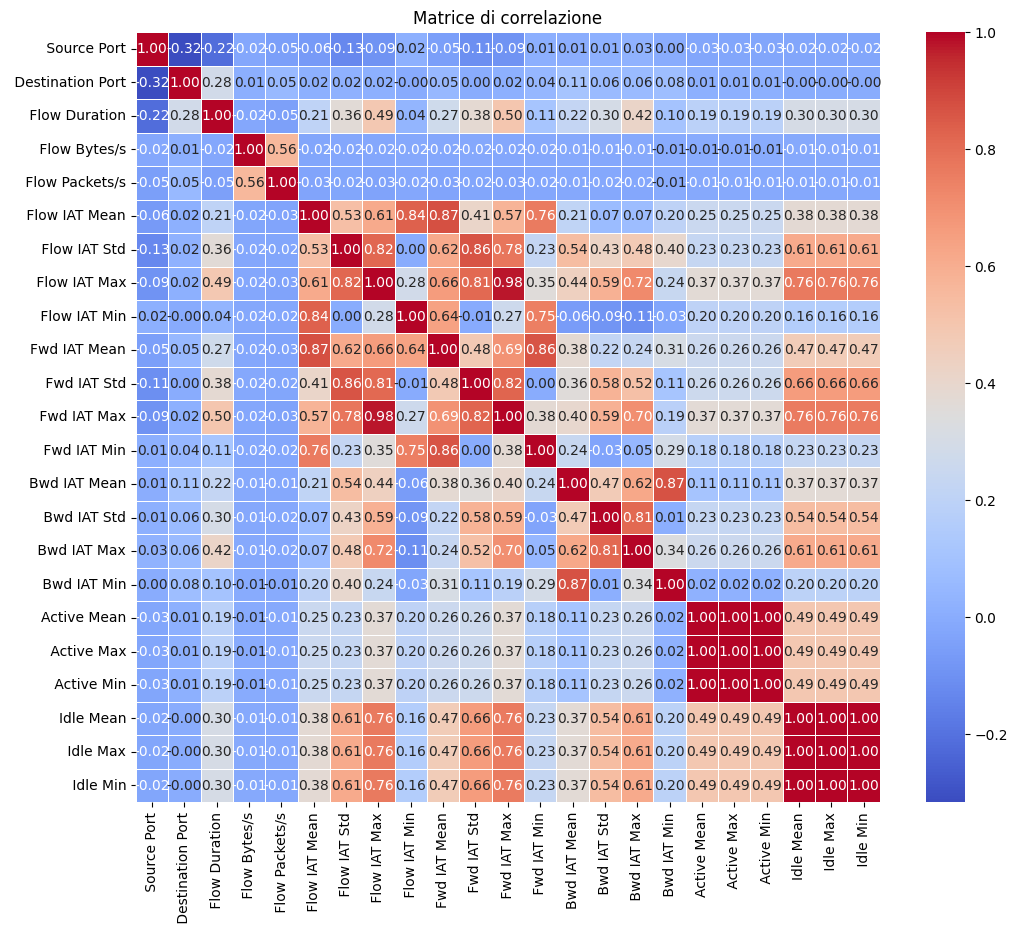

In [314]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matrice di correlazione')
plt.show()

### 4.6- Pipeline di preprocessing

Al termine dell'esplorazione delle feature è stata definita la funzione `preprocessing_pipeline`, progettata per eseguire una sequenza di operazioni di preprocessing su un DataFrame contenente dati relativi al traffico di rete. Questa sequenza di operazioni include:

1. **Eliminazione delle colonne altamente correlate**: Vengono identificate e rimosse le colonne numeriche che mostrano una correlazione superiore alla soglia specificata (`correlation_threshold`).

2. **One-Hot Encoding per le features categoriche**: Le colonne categoriche vengono sottoposte a one-hot encoding, riducendo il numero di categorie per ciascuna colonna alle prime `top_n_categories` categorie più frequenti.

La funzione restituisce un DataFrame preprocessato in base ai parametri inseriti, consentendo di ottenere facilmente più versioni dei dati, con diversi preprocessing, da testare in fase di validazione per trovare la configurazione migliore per ogni modello utilizzato.

In [315]:
def preprocessing_pipeline(df, correlation_threshold=0.8, top_n_categories=25):

    # 1. Eliminazione delle colonne altamente correlate
    def correlation(df, threshold):
        col_corr = set()
        corr_matrix = df.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold:
                    colname = corr_matrix.columns[i]
                    col_corr.add(colname)
        return col_corr

    correlated_columns = correlation(df[features_numeriche], correlation_threshold)
    df = df.drop(correlated_columns, axis=1)

    # 2. One-hot encoding per le features categoriche
    for column in features_categoriche:
        top_categories = df[column].value_counts().nlargest(top_n_categories).index
        df[column] = df[column].where(df[column].isin(top_categories), 'Other')
    df = pd.get_dummies(df, columns=features_categoriche, drop_first=True)

    return df

### 4.7- Suddivisione dataset

Definita una funzione per splittare il dataset in train, test e validation set.

In [316]:
def split_dataset(df):
    X = df.drop(columns=['label'])
    y = df['label']
    X_train_tot, X_test, y_train_tot, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_tot, y_train_tot, test_size=0.2, random_state=42)
    return X_train_tot, X_test, X_train, X_val, y_train_tot, y_test, y_train, y_val

### 4.8- Normalizzazione

Sono stati definiti tre approcci di standardizzazione o normalizzazione che verranno usati in seguito

In [317]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

## 5- Isolation Forest
spiegazione di come funziona todo

***-Anomaly Detection con Isolation Forest***

test con configurazione preprocessing e modello di base

In [318]:
df_preprocessed = preprocessing_pipeline(df, correlation_threshold=0.85, top_n_categories=0)
X_train_tot, X_test, X_train, X_val, y_train_tot, y_test, y_train, y_val = split_dataset(df_preprocessed)

In [319]:
model = IsolationForest()

In [320]:
model.fit(X_train)

IsolationForest()

In [321]:
predictions = model.predict(X_val)

In [322]:
label_mapping = {'TOR': -1, 'nonTOR': 1}
y_val_numeric = y_val.map(label_mapping)

In [323]:
print("Confusion Matrix:")
print(confusion_matrix(y_val_numeric, predictions))

print("\nClassification Report:")
print(classification_report(y_val_numeric, predictions))

Confusion Matrix:
[[ 139 1153]
 [ 869 8629]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.14      0.11      0.12      1292
           1       0.88      0.91      0.90      9498

    accuracy                           0.81     10790
   macro avg       0.51      0.51      0.51     10790
weighted avg       0.79      0.81      0.80     10790



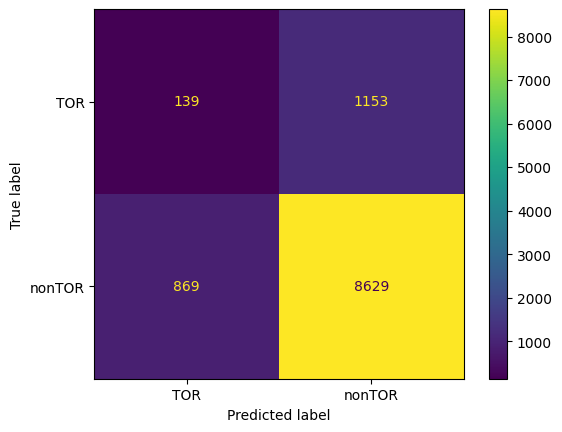

In [324]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_numeric, predictions), display_labels=['TOR', 'nonTOR'])
disp.plot()
disp.title = 'Confusion Matrix'
plt.show()

Passo il parametro contamination

In [525]:
df_preprocessed = preprocessing_pipeline(df, correlation_threshold=0.85, top_n_categories=0)
X_train_tot, X_test, X_train, X_val, y_train_tot, y_test, y_train, y_val = split_dataset(df_preprocessed)

In [526]:
X_train.drop(columns=[ ' Source Port', ' Destination Port',' Protocol'], inplace=True)
X_val.drop(columns=[ ' Source Port', ' Destination Port',' Protocol'], inplace=True)

In [527]:
model = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1, verbose=1, n_estimators=100, max_samples=0.9, max_features=0.15)

In [528]:
model.fit(X_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


IsolationForest(contamination=0.1, max_features=0.15, max_samples=0.9,
                n_jobs=-1, random_state=42, verbose=1)

In [529]:
predictions = model.predict(X_val)

In [530]:
label_mapping = {'TOR': -1, 'nonTOR': 1}
y_val_numeric = y_val.map(label_mapping)

In [531]:
print("Confusion Matrix:")
print(confusion_matrix(y_val_numeric, predictions))

print("\nClassification Report:")
print(classification_report(y_val_numeric, predictions))

Confusion Matrix:
[[ 171 1121]
 [ 938 8560]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.15      0.13      0.14      1292
           1       0.88      0.90      0.89      9498

    accuracy                           0.81     10790
   macro avg       0.52      0.52      0.52     10790
weighted avg       0.80      0.81      0.80     10790



## 6- Elliptic Envelope

## 7- Locally Outlier Factor (LOF)
Spiegazione di come funziona todo



***-Anomaly Detection con LOF***

## 8- Autoencoder
spiegazione di come funziona todo

***-Anomaly Detection con Autoencoder***

## 8- Confronto tra i modelli
todo

## 9- Conclusioni
todo